In [ ]:
%%javascript
IPython.notebook.clear_all_output();

# Download dataset

In [6]:
# Download the dataset
!wget http://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images.zip
!unzip ut-zap50k-images.zip > /dev/null

--2021-04-15 23:46:49--  http://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images.zip
Resolving vision.cs.utexas.edu (vision.cs.utexas.edu)... 128.83.120.116
Connecting to vision.cs.utexas.edu (vision.cs.utexas.edu)|128.83.120.116|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 305323328 (291M) [application/zip]
Saving to: ‘ut-zap50k-images.zip’

100%[======================================>] 305,323,328 44.7MB/s   in 17s    

2021-04-15 23:47:06 (17.4 MB/s) - ‘ut-zap50k-images.zip’ saved [305323328/305323328]



In [7]:
!rm -rf ut-zap50k-images.zip;

In [33]:
import os 
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from glob import glob
import matplotlib.image as image
import splitfolders 

from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
import tensorflow.keras.backend as Backend

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Lambda


In [14]:
dir_name = "./data"
isDir = os.path.isdir(dir_name) 
if not isDir:
    !mkdir data
    !mkdir data/Boots data/Sandals data/Shoes data/Slippers
    !find ut-zap50k-images/Boots -type f -name "*.jpg" | head -1500 | xargs -d '\n' mv -t data/Boots;
    !find ut-zap50k-images/Sandals -type f -name "*.jpg" | head -1500 | xargs -d '\n' mv -t data/Sandals;
    !find ut-zap50k-images/Shoes -type f -name "*.jpg" | head -1500 | xargs -d '\n' mv -t data/Shoes;
    !find ut-zap50k-images/Slippers -type f -print0 | xargs -0 mv -t data/Slippers;
    !rm -rf ut-zap50k-images;

In [6]:
dir_name = "./data"

files='**/*.jpg'
filenames = glob(os.path.join(dir_name, files))
classes = [os.path.basename(os.path.dirname(name)) for name in filenames]
count = list(Counter(classes).items())
print("Class count:", count);

Class count: [('Slippers', 1283), ('Sandals', 1500), ('Boots', 1500), ('Shoes', 1500)]


In [7]:
class_names = os.listdir(dir_name) # Get names of classes
class_name2id = { label: index for index, label in enumerate(class_names) } # Map class names to integer labels
print("Classes:", class_name2id)

labels = [class_name2id[c] for c in classes]
Counter(labels)

Classes: {'Slippers': 0, 'Sandals': 1, 'Boots': 2, 'Shoes': 3}


Counter({0: 1283, 1: 1500, 2: 1500, 3: 1500})

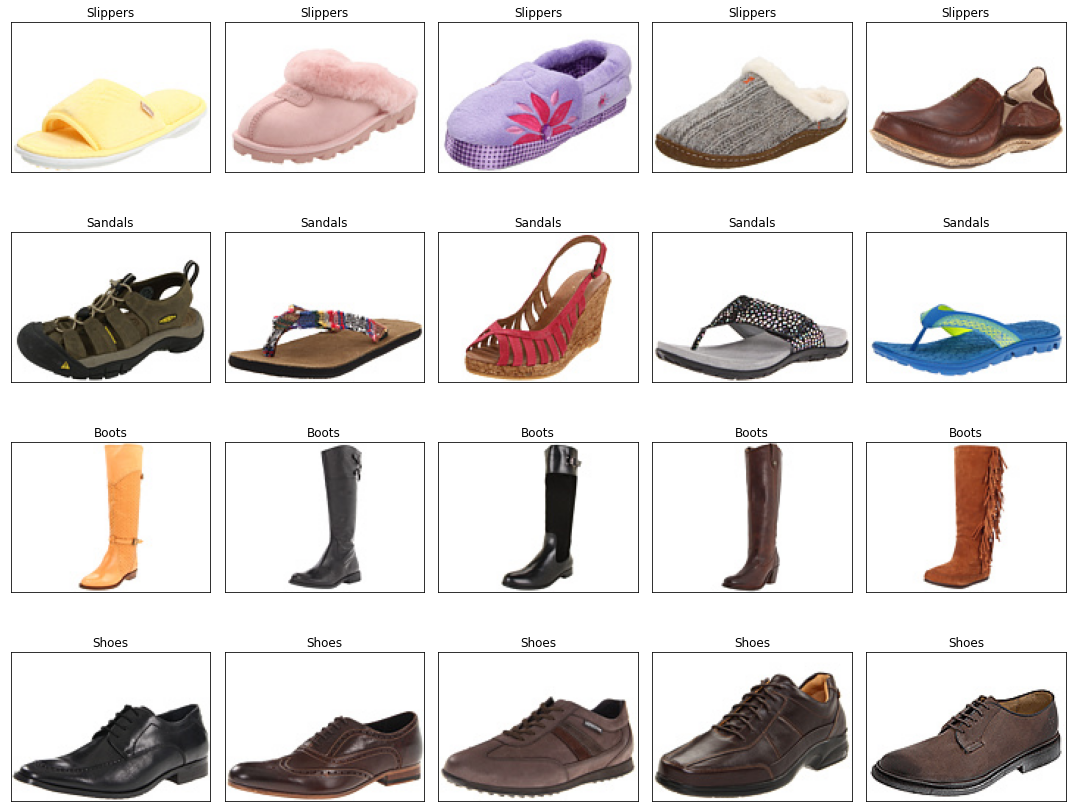

In [17]:
def visual_figure(ax, file, title):
    img = image.imread(file)
    ax.imshow(img)
    ax.title.set_text(title)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

fig = plt.figure(figsize=(15, 12))
axs = fig.subplots(4, 5)
for i in range(5):
    id_1 = i+count[0][1]
    id_2 = id_1+count[1][1]
    id_3 = id_2+count[2][1]
    visual_figure(axs[0,i], filenames[i], classes[i])
    visual_figure(axs[1,i], filenames[id_1], classes[id_1])
    visual_figure(axs[2,i], filenames[id_2], classes[id_2])
    visual_figure(axs[3,i], filenames[id_3], classes[id_3])
fig.tight_layout()

# Processing dataset

In [18]:
# split dataset into train, test and validation
splitfolders.ratio('data', output="splitted_data", seed=1337, ratio=(.8, 0.1,0.1))

In [18]:
# config
IMG_SHAPE = (64, 64, 3)
IMG_SIZE = (64, 64) 
BATCH_SIZE = 32
EPOCHS = 32

In [3]:
def get_image(filename):
    img_obj = load_img(filename, target_size=IMG_SIZE) # image object
    numpy_image = img_to_array(img_obj) # image object -> pixel array
    return numpy_image

def map_dataset(filenames):
    data = []
    for i in range(len(filenames)):
        data.append(get_image(filenames[i]))
        if(i % 1000 == 0): print(i, 'images loaded')
    return np.array(data)/255.0

def get_files_labels(path):
    files = glob(os.path.join(path, '**/*.jpg'))
    classes = [os.path.basename(os.path.dirname(name)) for name in files]
    labels = [class_name2id[c] for c in classes]
    return files, np.array(labels)
    

In [8]:
train_path = "splitted_data/train"
train_files, train_y = get_files_labels(train_path)
print("Train:", Counter(train_y))

test_path = "splitted_data/test"
test_files, test_y = get_files_labels(test_path)
print("Test:", Counter(test_y))

val_path = "splitted_data/val"
val_files, val_y = get_files_labels(val_path)
print("Validation:", Counter(val_y))


Train: Counter({1: 1200, 2: 1200, 3: 1200, 0: 1026})
Test: Counter({1: 150, 2: 150, 3: 150, 0: 129})
Validation: Counter({1: 150, 2: 150, 3: 150, 0: 128})


In [9]:
train_X = map_dataset(train_files)
test_X = map_dataset(test_files)
val_X = map_dataset(val_files)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.48 µs
0 images loaded
1000 images loaded
2000 images loaded
3000 images loaded
4000 images loaded
0 images loaded
0 images loaded


In [30]:
print(train_X.shape)
print(train_y.shape)
# print(train_X[0])

(4626, 64, 64, 3)
(4626,)


# Make Pairs for Siamese Network

In [10]:
def make_pos_neg_pairs(X, y):
    pairs = [] # (image, image) pair 
    labels = [] # 0 means negative pair, otherwise, positive
    
    class_count = len(np.unique(y))
    class_indexes = [np.where(y == i)[0] for i in range(0, class_count)]
    
    for i in range(len(X)):
        cur_img = X[i]
        cur_label = y[i]
        
        # positive: pick an image from same class randomly
        pos_i = np.random.choice(class_indexes[cur_label]) 
        pos_img = X[pos_i]
        pairs.append([cur_img, pos_img])
        labels.append([1])
        
        # negative: pick an image from other classes randomly
        neg_ids = np.where(y != cur_label)[0]
        neg_img = X[np.random.choice(neg_ids)]        
        pairs.append([cur_img, neg_img])
        labels.append([0])
        
    return (np.array(pairs), np.array(labels))

In [11]:
(train_paris, train_labels) = make_pos_neg_pairs(train_X, train_y)
(val_paris, val_labels) = make_pos_neg_pairs(val_X, val_y)

In [33]:
print(train_paris.shape)
print(train_labels.shape)
print(val_paris.shape)
print(val_labels.shape)

(9252, 2, 64, 64, 3)
(9252, 1)
(1156, 2, 64, 64, 3)
(1156, 1)


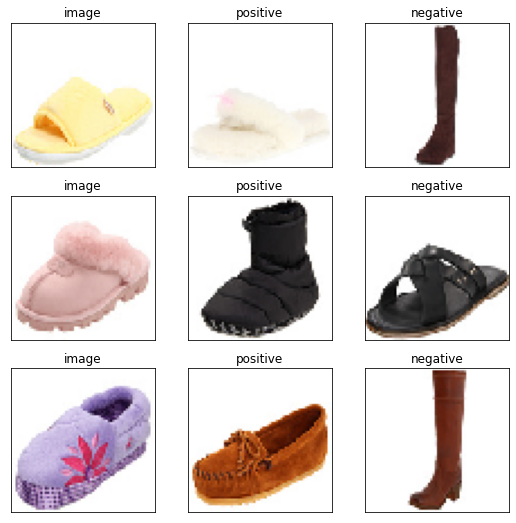

In [34]:
def show(ax, image, title):
    ax.imshow(image)
    ax.set_title(title)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
fig = plt.figure(figsize=(9, 9))
axs = fig.subplots(3, 3)
for i in range(3):
    show(axs[i, 0], train_paris[2*i][0], "image")
    show(axs[i, 1], train_paris[2*i][1], "positive")
    show(axs[i, 2], train_paris[2*i+1][1], "negative")

# Build Siamese Network

In [37]:
def siamese_model(shape, embedding_d=512): # instade of 48
    inputs = Input(shape)
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    
    global_pool = Flatten()(x) # instade of GlobalAveragePooling2D
    outputs = Dense(embedding_d)(global_pool)
    
    model = Model(inputs, outputs)
    
    return model

In [13]:
def cal_euclidean_distance(vector_tuple):
    (vector_1, vector_2) = vector_tuple
    sqr_sum = Backend.sum(Backend.square(vector_1 - vector_2), axis=1, keepdims=True)
    distance = Backend.sqrt(Backend.maximum(sqr_sum, Backend.epsilon()))
    return distance   

In [38]:
input_1 = Input(shape=IMG_SHAPE)
input_2 = Input(shape=IMG_SHAPE)
ext_features = siamese_model(IMG_SHAPE)
features_1 = ext_features(input_1)
features_2 = ext_features(input_2)
euc_distance = Lambda(cal_euclidean_distance)([features_1, features_2])
sia_model = Model(inputs=[input_1, input_2], outputs=euc_distance)
sia_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
model_5 (Model)                 (None, 512)          8406400     input_8[0][0]                    
                                                                 input_9[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 1)            0           model_5[1][0]              

In [39]:
ext_features.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 64)        832       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        16448     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 16, 64)        0   

# Trianing Model 

In [40]:
import time

In [41]:
def cal_loss(y, pred, margin=1):
    y = tf.cast(y, pred.dtype)
    square = Backend.square(pred)
    margin_square = Backend.square(Backend.maximum(margin - pred, 0))
    loss = Backend.mean(y * square + (1 - y) * margin_square)
    return loss

In [42]:
sia_model.compile(loss=cal_loss, optimizer="adam")

start_time = time.time()

history = sia_model.fit(
    [train_paris[:, 0], train_paris[:, 1]], train_labels[:],
    validation_data=([val_paris[:, 0], val_paris[:, 1]], val_labels[:]),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS)

print(f"\nTrained for {(time.time() - start_time) / 60} minutes ")

Epoch 1/32
290/290 [==============================] - 3s 11ms/step - loss: 0.8810 - val_loss: 0.1829
Epoch 2/32
290/290 [==============================] - 3s 11ms/step - loss: 0.1693 - val_loss: 0.1831
Epoch 3/32
290/290 [==============================] - 3s 11ms/step - loss: 0.1591 - val_loss: 0.1559
Epoch 4/32
290/290 [==============================] - 3s 11ms/step - loss: 0.1549 - val_loss: 0.1498
Epoch 5/32
290/290 [==============================] - 3s 11ms/step - loss: 0.1530 - val_loss: 0.1664
Epoch 6/32
290/290 [==============================] - 3s 11ms/step - loss: 0.1525 - val_loss: 0.1685
Epoch 7/32
290/290 [==============================] - 3s 11ms/step - loss: 0.1476 - val_loss: 0.1400
Epoch 8/32
290/290 [==============================] - 3s 11ms/step - loss: 0.1448 - val_loss: 0.1649
Epoch 9/32
290/290 [==============================] - 3s 11ms/step - loss: 0.1466 - val_loss: 0.1406
Epoch 10/32
290/290 [==============================] - 3s 11ms/step - loss: 0.1440 - val_lo

In [132]:
# print(history.history["loss"])

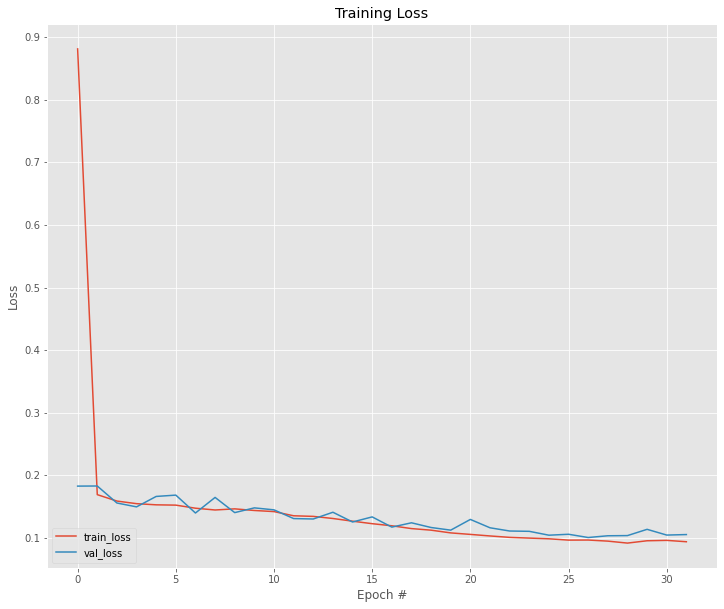

In [43]:
plt.style.use("ggplot")
plt.figure(figsize=(12, 10))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

In [44]:
(test_paris, test_labels) = make_pos_neg_pairs(test_X, test_y)

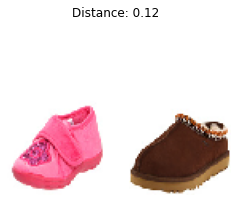

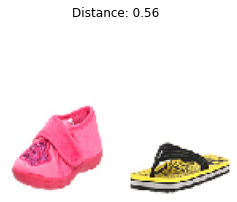

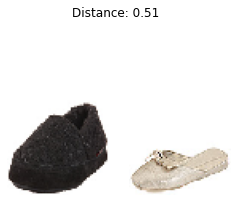

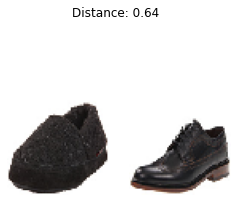

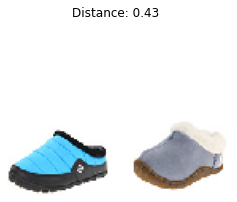

In [45]:


for i in range(5):
    imageA = np.expand_dims(test_paris[i][0], axis=0)
    imageB = np.expand_dims(test_paris[i][1], axis=0)
    preds = sia_model.predict([imageA, imageB])
    proba = preds[0][0]
    
    fig = plt.figure("Pair #{}".format(i + 1), figsize=(4, 4))
    plt.suptitle("Distance: {:.2f}".format(proba))
    
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(test_paris[i][0])
    plt.axis("off")
    
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(test_paris[i][1])
    plt.axis("off")
    
    plt.show()
    

In [180]:
# def show(ax, image, title):
#     ax.imshow(image)
#     ax.set_title(title)
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
    
# fig = plt.figure(figsize=(6, 6))
# axs = fig.subplots(2, 2)
# for i in range(2):
#     show(axs[i, 0], test_X[i*2], "")
#     show(axs[i, 1], test_X[i*2+1], "")

In [147]:
# preds = sia_model.predict([test_X[0], test_X[1]])

In [178]:
# imageA = np.expand_dims(test_X[0], axis=0)
# imageB = np.expand_dims(test_X[5], axis=0)

In [155]:
# preds = sia_model.predict([imageA, imageB])

In [179]:
# print(preds)

# Single layer classifier

In [23]:
# input_1 = Input(shape=IMG_SHAPE)
ext_features = siamese_model(IMG_SHAPE)
# features_1 = ext_features(input_1)

In [46]:
train_fetures = ext_features(train_X)
val_fetures = ext_features(val_X)
test_fetures = ext_features(test_X)

In [47]:
train_fetures.shape, train_X.shape, train_y.shape

(TensorShape([4626, 512]), (4626, 64, 64, 3), (4626,))

In [55]:
class_model = tf.keras.Sequential(name="class_model")
# class_model.add(tf.keras.layers.Dense(128, activation='relu', name="dense_layer1"))
class_model.add(tf.keras.layers.Dense(4, activation='softmax', name="predictions"))
# class_model.add(layers.Dense(4, name="layer3"))

In [56]:
from tensorflow.keras.optimizers import SGD
import time

class_model.compile(optimizer=SGD(lr=0.001, momentum=0.9), 
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                    metrics=["accuracy"]
                    )

start_time = time.time()

history = class_model.fit(x=train_fetures, y= train_y, 
                          epochs=90, 
                          validation_data=(val_fetures, val_y),
)

print(f"\nTrained for {(time.time() - start_time) / 60} minutes ")

Epoch 1/90
145/145 [==============================] - 0s 2ms/step - loss: 1.3766 - accuracy: 0.4341 - val_loss: 1.3411 - val_accuracy: 0.6817
Epoch 2/90
145/145 [==============================] - 0s 2ms/step - loss: 1.3090 - accuracy: 0.7492 - val_loss: 1.2785 - val_accuracy: 0.7301
Epoch 3/90
145/145 [==============================] - 0s 2ms/step - loss: 1.2469 - accuracy: 0.7611 - val_loss: 1.2215 - val_accuracy: 0.7422
Epoch 4/90
145/145 [==============================] - 0s 2ms/step - loss: 1.1900 - accuracy: 0.7646 - val_loss: 1.1692 - val_accuracy: 0.7422
Epoch 5/90
145/145 [==============================] - 0s 2ms/step - loss: 1.1378 - accuracy: 0.7657 - val_loss: 1.1213 - val_accuracy: 0.7439
Epoch 6/90
145/145 [==============================] - 0s 2ms/step - loss: 1.0899 - accuracy: 0.7670 - val_loss: 1.0773 - val_accuracy: 0.7491
Epoch 7/90
145/145 [==============================] - 0s 2ms/step - loss: 1.0457 - accuracy: 0.7713 - val_loss: 1.0370 - val_accuracy: 0.7509
Epoch 

In [57]:
y_pred = class_model.predict(test_fetures)


In [58]:
from sklearn.metrics import classification_report

# encode the test data
# y_pred = model5.predict(test_ds)

# calculate classification accuracy
report = classification_report(test_y, np.argmax(y_pred, axis=1), digits=4)
print(report)

print('---------------------------------------')
print()

# from sklearn.metrics import roc_auc_score
# AUC = roc_auc_score(y_test, np.argmax(y_pred, axis=1))
# print('AUC: ', AUC)
# print()

              precision    recall  f1-score   support

           0     0.8879    0.7984    0.8408       129
           1     0.9062    0.9667    0.9355       150
           2     0.9615    1.0000    0.9804       150
           3     0.9252    0.9067    0.9158       150

    accuracy                         0.9223       579
   macro avg     0.9202    0.9179    0.9181       579
weighted avg     0.9214    0.9223    0.9209       579

---------------------------------------



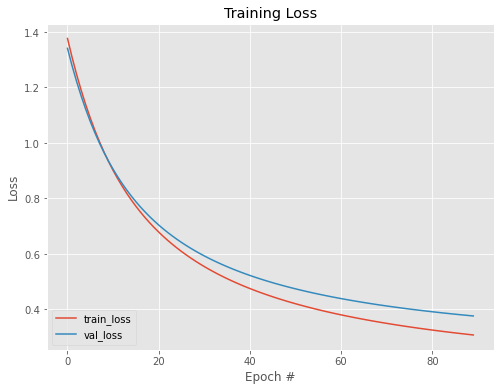

In [60]:
plt.style.use("ggplot")
plt.figure(figsize=(8, 6))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

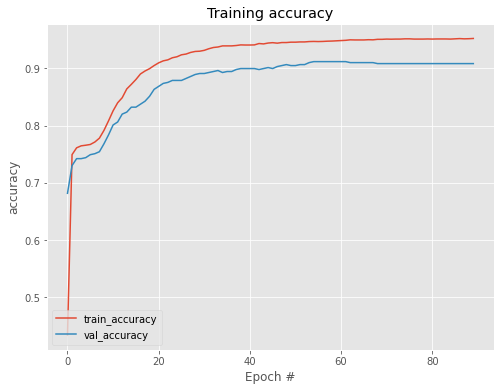

In [62]:
plt.style.use("ggplot")
plt.figure(figsize=(8, 6))
plt.plot(history.history["accuracy"], label="train_accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.title("Training accuracy")
plt.xlabel("Epoch #")
plt.ylabel("accuracy")
plt.legend(loc="lower left")